# 긍부정 판별을 위한 KoBERT 모델 생성

In [ ]:
# 필요 모듈 설치

!pip install transformers
!pip install sentencepiece
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.1 MB/s eta 0:00:00


In [ ]:
## 필요 모듈 import 

import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm

import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

In [ ]:
# 구글드라이브 실행

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 불러들이기

df_train = pd.read_csv('./data/df_train_eda_total_len_less_6_filtered.csv',encoding='utf-8-sig')
df_test = pd.read_csv('./data/df_test_eda_total_len_less_6_filtered.csv',encoding='utf-8-sig')

In [ ]:
## 중복 row 제거
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()
df_no_star = df_no_star.drop_duplicates()

# review NaN인 row drop
df_train = df_train.dropna(subset='review_content')
df_test = df_test.dropna(subset='review_content')
df_no_star = df_no_star[df_no_star['review_content'].notnull()]

# reset index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_no_star.reset_index(drop=True, inplace=True)


# 변수명 수정
train, test = df_train, df_test

In [ ]:
# value count 확인

test['rating'].value_counts(),train['rating'].value_counts()

(1.0    38357
 0.0     4100
 Name: rating, dtype: int64,
 1.0    153426
 0.0    147591
 Name: rating, dtype: int64)

## 버트 인풋 만들기

한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.
이번에는 한국어 데이터로 훈련되었고, SKT에서 만든 KoBERT를 사용하도록 하겠습니다.
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.
https://github.com/monologg/KoBERT-NER 에서 kobert를 tokenize 할 수 있는 코드를 가져왔습니다.

In [ ]:
# KoBERT 토크나이저를 활용

import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece `_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [ ]:
# monologg/kobert 모델을 사용하여 KoBertTokenizer 객체를 생성한다.

tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')  

loading file tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/tokenizer_78b3253a26.model
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_d

In [ ]:
# 데이터 변환을 위한 함수

def convert_data(data_df):
    global tokenizer

    SEQ_LEN = 64  # SEQ_LEN : 버트에 들어갈 인풋의 길이

    tokens, masks, segments, targets = [], [], [], []

    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(
            data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)

        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros

        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의


def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y


SEQ_LEN = 64
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "review_content"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "rating"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)


100%|██████████| 301017/301017 [01:11<00:00, 4195.47it/s]


In [ ]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 42457/42457 [00:09<00:00, 4466.89it/s]


## 버트를 활용한 감성분석 모델 만들기

In [ ]:
model = TFBertModel.from_pretrained(
    "monologg/kobert", from_pt=True)  # monologg/kobert 모델 불러오기


# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_word_ids')  # 입력 토큰 정의
mask_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_masks')  # 입력 마스크 정의
segment_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_segment')  # 입력 세그먼트 정의


# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model(
    [token_inputs, mask_inputs, segment_inputs])  # bert 모델의 출력 정의


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/config.json
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.32.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/30941062c0f3dde73b246468f449f2448c7694bc/pytorch_model.bin
Loading PyTorch weights from /root/.cache/huggingface/hub/models--monologg-

In [ ]:
# fine-tuning을 적용을 위해 index 1로 적용

bert_outputs = bert_outputs[1]

In [ ]:
bert_outputs[1]

<KerasTensor: shape=(768,) dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [ ]:
# Rectified Adam 옵티마이저 생성
# Adam보다 초기 학습에서의 강점

opt = tfa.optimizers.RectifiedAdam(
    lr=5.0e-5,  # learning rate 설정
    total_steps=2344*2,  # 총 스텝 수 설정
    warmup_proportion=0.1,  # warmup 비율 설정

)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# fine-tuning을 위한 모델링 설정

sentiment_drop = tf.keras.layers.Dropout(
    0.5)(bert_outputs)  # BERT 출력값에 드롭아웃 적용

sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(
    stddev=0.02))(sentiment_drop)  # 드롭아웃 적용된 BERT 출력값에 fully connected layer 적용

sentiment_model = tf.keras.Model(
    [token_inputs, mask_inputs, segment_inputs], sentiment_first)  # 입력값과 출력값을 지정하여 모델 생성
    
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                        'acc'])  # 모델 컴파일, optimizer는 Adam, loss는 binary crossentropy, 평가 지표는 accuracy


In [ ]:
# model summary 확인

sentiment_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',      

In [ ]:
# GPU를 사용하기 위해 런타임 유형을 GPU로 변경

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)


# GPU를 사용하기 위한 설정
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# 모델 학습
with tf.device('/device:GPU:0'):
  history = sentiment_model.fit(train_x, train_y, epochs=10, shuffle=True,
                      batch_size=64,callbacks=es, validation_data=(test_x, test_y))


Found GPU at: /device:GPU:0
Epoch 1/10
4704/4704 [==============================] - 1397s 292ms/step - loss: 0.2696 - acc: 0.8829 - val_loss: 0.1865 - val_acc: 0.9288
Epoch 2/10
4704/4704 [==============================] - 1367s 291ms/step - loss: 0.1537 - acc: 0.9423 - val_loss: 0.1865 - val_acc: 0.9288
Epoch 3/10
4704/4704 [==============================] - 1364s 290ms/step - loss: 0.1533 - acc: 0.9423 - val_loss: 0.1865 - val_acc: 0.9288
Epoch 4/10
4704/4704 [==============================] - 1361s 289ms/step - loss: 0.1533 - acc: 0.9422 - val_loss: 0.1865 - val_acc: 0.9288
Epoch 4: early stopping


## predict

In [ ]:
# 예측에 필요한 함수 적용

def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for i in tqdm(range(len(data_df))):  # 데이터프레임의 길이만큼 반복문 실행

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN,
                                 truncation=True, padding='max_length')  # 문장을 토큰화하여 인코딩
        num_zeros = token.count(0)  # 0의 개수를 세어 num_zeros에 저장
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # mask 생성
        segment = [0]*SEQ_LEN  # segment 생성

        tokens.append(token)  # tokens 리스트에 token 추가
        segments.append(segment)  # segments 리스트에 segment 추가
        masks.append(mask)  # masks 리스트에 mask 추가

    tokens = np.array(tokens)  # tokens 리스트를 numpy 배열로 변환
    masks = np.array(masks)  # masks 리스트를 numpy 배열로 변환
    segments = np.array(segments)  # segments 리스트를 numpy 배열로 변환
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의


def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(
        str)  # 데이터프레임의 DATA_COLUMN 열을 문자열로 변환
    data_x = predict_convert_data(data_df)  # convert_data 함수를 이용하여 데이터 전처리
    return data_x


In [ ]:
# 데이터 변환

test_set = predict_load_data(test)

100%|██████████| 42457/42457 [00:09<00:00, 4652.32it/s]


In [ ]:
# predict

preds = sentiment_model.predict(test_set)

1327/1327 [==============================] - 78s 56ms/step


In [ ]:
# classification_report 출력하여 확인

from sklearn.metrics import classification_report
y_true = test['rating']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.60      0.80      0.68      4100
           1       0.98      0.94      0.96     38357

    accuracy                           0.93     42457
   macro avg       0.79      0.87      0.82     42457
weighted avg       0.94      0.93      0.93     42457



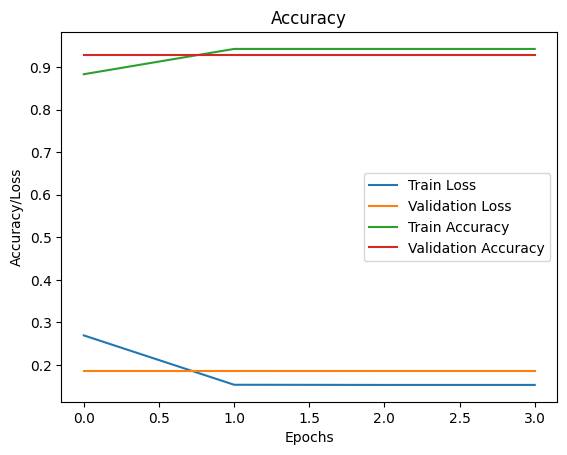

In [ ]:
# loss와 accuracy를 시각화

import matplotlib.pyplot as plt


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()


In [ ]:
# 모델 저장

sentiment_model.save_weights("./판별기/ckpt_eda_data")

## 생성 모델로 예측

In [ ]:
import logging  # logging 모듈을 import 합니다.
tf.get_logger().setLevel(logging.ERROR)  # tensorflow의 logger를 ERROR 레벨로 설정합니다.


In [ ]:

def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN,
                             truncation=True, padding='max_length')

    num_zeros = token.count(0)  # 패딩으로 추가된 0의 개수를 세어준다.
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # 패딩 부분은 0으로 마스킹한다.
    segment = [0]*SEQ_LEN  # 문장의 길이만큼 segment를 0으로 채운다.

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]


def review_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value, 0).item()

    if predict_answer == 0:
      # 예측값이 0일 경우, 부정적인 평가로 판단한다.
      print(sentence)
      print("(부정 확률 : %.2f) 부정적인 평가입니다." % (1-predict_value))
      print('='*60)
    # elif predict_answer == 1:
    #   # 예측값이 1일 경우, 긍정적인 평가로 판단한다.
    #   print(sentence)
    #   print("(긍정 확률 : %.2f) 긍정적인 평가입니다." % predict_value)
    #   print('='*60)


In [ ]:
# pred 할 파일 불러들이기

df_input = pd.read_csv('./data/review_concat_rating_revised_prep.csv',encoding='utf-8-sig')

In [ ]:
# 부른 파일 pred

test_set = predict_load_data(df_input)
preds = sentiment_model.predict(test_set)

100%|██████████| 112340/112340 [00:23<00:00, 4810.65it/s]


3511/3511 [==============================] - 198s 56ms/step


In [ ]:
# pred 결과 dataframe에 추가

df_input['pred_proba'] = preds.reshape(-1)
df_input['pred_rating'] = np.nan
df_input.loc[df_input['pred_proba'] > 0.5,'pred_rating'] = 1
df_input.loc[df_input['pred_proba'] <= 0.5,'pred_rating'] = 0
df_input

,Unnamed: 0,restaurant_name,review_content,rating,date,visit,register,category,org_review_content,pred_proba,pred_rating
0,0,전포동 베이비치크,아기자기하고 빈티지한 분위기가 좋았어요 명란청양오일파스타랑 트러플버섯크림리조또 먹었...,NaN,2023-08-02,1,영수증,양식,아기자기하고 빈티지한 분위기가 좋았어요ㅎㅎ 명란청양오일파스타랑 트러플버섯크림리조또 ...,0.997354,1.0
1,1,전포동 베이비치크,입구부터 이쁜 공간이 너무 많아서 좋았던 이곳 취향저격 제대로 당해서 안으로 들어왔...,NaN,2023-08-01,1,영수증,양식,입구부터 이쁜 공간이 너무 많아서 좋았던 이곳 취향저격 제대로 당해서 안으로 들어왔...,0.997815,1.0
2,2,전포동 베이비치크,와 오랜만에 너무 만족스러운 식사하고 왔어여 매장 분위기도 너무 좋고 예쁘신 ...,NaN,2023-07-24,1,영수증,양식,와..오랜만에 너무 만족스러운 식사하고 왔어여ㅠ 매장 분위기도 너무 좋고 예쁘신 사...,0.997788,1.0
3,3,전포동 베이비치크,지난번에 너무 맛있게 먹고 이번에 재방문했어요 베이비치크 플레이트는 진짜 무조건...,NaN,2023-08-09,1,영수증,양식,지난번에 너무 맛있게 먹고 이번에 재방문했어요! 베이비치크 플레이트는 진짜 무조건 ...,0.997869,1.0
4,4,전포동 베이비치크,양 진짜 많고 너무 맛있어요 안에도 아기자기 앤티크하게 잘 꾸며져있고 감성도 맛도 ...,NaN,2023-07-05,1,영수증,양식,양 진짜 많고 너무 맛있어요ㅠㅠ 안에도 아기자기 앤티크하게 잘 꾸며져있고ㅠㅠㅠ 감성...,0.997817,1.0
...,...,...,...,...,...,...,...,...,...,...,...
112335,116259,양정동 명심이족발,맛있어요,5.0,2020-12-19,1,영수증,"족발,보쌈",맛있어요,0.905437,1.0
112336,116260,양정동 명심이족발,맛있고 양도 많았어요,5.0,2020-12-25,2,영수증,"족발,보쌈",맛있고 양도 많았어요!,0.985904,1.0
112337,116261,양정동 명심이족발,좋아요,3.5,2020-10-29,1,영수증,"족발,보쌈",좋아요,0.913858,1.0
112338,116262,양정동 명심이족발,맛있어요,3.5,2019-12-15,1,영수증,"족발,보쌈",맛있어요,0.905437,1.0


In [ ]:
# 결과 데이터프레임 저장

df_input.to_excel("./data/230824_df_input_preped_with_pred_6차.xlsx")